In [37]:
from google.colab import drive
drive.mount('/content/gdrive')
dataset_path = "gdrive/My Drive/Colab Notebooks/DEEP LEARNING/deeplearning3/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
import copy

In [0]:
series = loadmat(dataset_path + 'data.mat')
series = series['X']

In [0]:
n_observations = np.arange(series.shape[0]) 
variables_name = ["Wind speed","Wind direction", "Temperature", "Dew Point","Air Pressure"]
n_cities = series.shape[1]
n_variables = series.shape[2]

In [0]:
# fig, axs = plt.subplots(n_cities, n_variables, figsize = (35,20))
# for city in range(n_cities):
#   for variable in range(n_variables):
#     axs[city, variable].plot(n_observations, series[:, city, variable])
#     axs[city, variable].set_title('City: ' + str(city + 1) + ", Variable: " + str(variables_name[variable]))  

In [0]:
def scale_data(data, variable):
  v_min = data[:,:,variable].min()
  v_max = data[:,:,variable].max()
  scaled_data = (data[:,:,variable] - v_min)/(v_max - v_min)
  return scaled_data

In [0]:
def inverse_scale(original_data, scaled_data, variable):
  v_min = original_data[:,:,variable].min()
  v_max = original_data[:,:,variable].max()
  inverse_scale_data = scaled_data[:,:,variable] * (v_max - v_min) + v_min
  return inverse_scale_data

In [0]:
scaled_data = np.zeros(series.shape)
for variable in range(n_variables):
  scaled_data[:,:,variable] = scale_data(series, variable)

In [0]:
test_series_size = 168
train_series = scaled_data[:-test_series_size,:,:]
test_series = scaled_data[-test_series_size:,:,:]

In [0]:
def create_dataset(data, time_steps):
  samples = data.shape[0] - time_steps
  channel_to_predict = 2
  city_to_predict = 3
  X = np.zeros((samples, time_steps, data.shape[1], data.shape[2]))
  y = np.zeros((samples))
  for i in range(samples):
    for j in range(time_steps):
      X[i, j, : , :] =  data[i + j, :, :]
    y[i] = data[i + j + 1, city_to_predict, channel_to_predict]
  return X, y 

In [0]:
time_step = 48
validation_set_size = 100
X, y = create_dataset(train_series, time_step)

In [0]:
def CNN_model(X,y):
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=X_train[0].shape, data_format="channels_last"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(64, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(32, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(8, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(1, kernel_initializer= 'normal', activation='relu'))
  model.compile(optimizer='adam', loss='mse')
  model.fit(X, y, epochs=100, verbose=1, batch_size=32)
  return model

In [0]:
model = CNN_model(X_train,y_train)

In [0]:
channel_to_predict = 2
city_to_predict = 3 
series_input = train_series[-time_step:,:,:]
for i in range(test_series.shape[0]):
  y_pred = model.predict(series_input.reshape(1,series_input.shape[0], series_input.shape[1],series_input.shape[2]))
  series_input = np.delete(series_input, obj=0, axis=0)
  test_series[i,city_to_predict,channel_to_predict] = y_pred
  series_input = np.append(series_input, test_series[i].reshape(1,test_series.shape[1], test_series.shape[2] ), axis=0)

In [0]:
predicted_temperature = inverse_scale(series, test_series, channel_to_predict)[:,city_to_predict]

In [0]:
series = loadmat(dataset_path + 'data.mat')
series = series['X']
real_temperature_values = series[-test_series_size:,city_to_predict,channel_to_predict]

In [22]:
MAE = mean_absolute_error(real_temperature_values, predicted_temperature)
print(MAE)

10.870505901497035


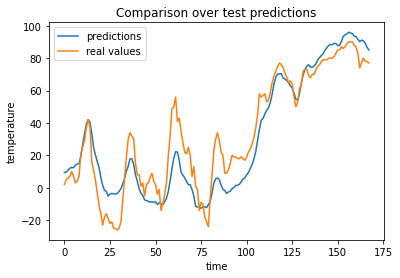

In [23]:
n_observations = np.arange(test_series.shape[0]) 
plt.plot(n_observations, predicted_temperature, label='predictions')
plt.plot(n_observations, real_temperature_values, label='real values')
plt.title("Comparison over test predictions")
plt.xlabel('time')
plt.ylabel('temperature')
plt.legend()
plt.show()

In [0]:
# run a repeated experiment
def experiment(lag,repeats):
  # run experiment
  error_scores = list()
  
  for r in range(repeats):
    model = CNN_model()
    rmse = validation_model()
    error_scores.append(MAE)  
  
  return error_scores

In [0]:
# load dataset
series = loadmat(dataset_path + 'data.mat')
series = series['X']

#scale data
scaled_data = np.zeros(series.shape)
for variable in range(n_variables):
  scaled_data[:,:,variable] = scale_data(series, variable)

test_series_size = 168
train_series = scaled_data[:-test_series_size,:,:]
test_series = scaled_data[-test_series_size:,:,:]
# experiment
repeats = 5
n_lags = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
count = 0

for lag in n_lags:
  print("---------------------------------------------------------------------------")
  count  = count + 1
  print("model = ", count)
  results[str(count)] = experiment(lag)
# summarize results
print(results.describe())
# save boxplot
results.boxplot(figsize=(28, 12))